In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import preprocessing
import pathlib
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split,GridSearchCV
import pandas as pd
from collections import Counter,defaultdict
import seaborn as sns
import os
import time
import imagehash
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples,confusion_matrix,recall_score,precision_score
import matplotlib.cm as cm
from sklearn.model_selection import KFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#bee_ds, bee_info = tfds.load('bee_dataset/bee_dataset_150',split='train',shuffle_files=True,with_info=True)

In [5]:

#tfds.show_examples(bee_ds,bee_info)

Desde google collab exporto el dataset en formato json a local para hacer el ejercicio desde mi propia maquina, se exporto en json y no en csv ni ningun otro formato dado que este formato era el unico capaz de mantener los datos de las imagenes en un formato legible, en los otros formatos los arrays se separaban con /n y no se podia hacer ninguna transformacion posible para arreglar eso

In [6]:
#bee_df = tfds.as_dataframe(bee_ds,bee_info)
bee_df = pd.read_json("C:/Users/javip/god/bees.json")

In [7]:
bee_df.head()

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output
0,"[[[88, 85, 78], [97, 97, 87], [108, 111, 100],...",0,0,0,0
1,"[[[133, 224, 183], [134, 225, 184], [134, 226,...",0,1,0,0
2,"[[[91, 94, 85], [86, 89, 80], [79, 82, 75], [7...",0,1,0,0
3,"[[[151, 227, 181], [151, 227, 181], [154, 230,...",0,1,0,0
4,"[[[138, 223, 190], [136, 221, 188], [135, 222,...",0,0,0,0


In [8]:
bee_df.tail()

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output
7485,"[[[132, 223, 190], [131, 222, 189], [131, 222,...",1,0,0,0
7486,"[[[140, 222, 182], [139, 221, 181], [142, 224,...",0,1,0,0
7487,"[[[119, 103, 103], [121, 107, 106], [108, 94, ...",0,1,0,0
7488,"[[[125, 227, 190], [123, 225, 188], [123, 225,...",0,0,0,1
7489,"[[[132, 226, 189], [129, 223, 186], [127, 221,...",0,0,1,0


In [9]:
for i in range(len(bee_df["input"])):
    bee_df["input"].loc[i]=np.array(bee_df["input"][i])

In [10]:
bee_df['input'][0]

array([[[ 88,  85,  78],
        [ 97,  97,  87],
        [108, 111, 100],
        ...,
        [151, 232, 199],
        [151, 232, 199],
        [149, 233, 199]],

       [[ 77,  74,  67],
        [ 84,  84,  76],
        [ 96,  99,  88],
        ...,
        [145, 226, 193],
        [147, 228, 195],
        [146, 230, 196]],

       [[ 67,  62,  58],
        [ 76,  73,  66],
        [ 88,  90,  79],
        ...,
        [143, 224, 191],
        [146, 227, 194],
        [148, 230, 194]],

       ...,

       [[150, 234, 200],
        [153, 237, 203],
        [152, 236, 202],
        ...,
        [155, 236, 203],
        [155, 236, 203],
        [156, 238, 202]],

       [[149, 233, 197],
        [154, 238, 202],
        [153, 237, 201],
        ...,
        [156, 237, 204],
        [155, 236, 203],
        [154, 236, 200]],

       [[149, 233, 197],
        [155, 239, 203],
        [154, 238, 202],
        ...,
        [157, 238, 205],
        [155, 236, 203],
        [153, 235, 199]]

In [11]:
bee_df.columns

Index(['input', 'output/cooling_output', 'output/pollen_output',
       'output/varroa_output', 'output/wasps_output'],
      dtype='object')

In [12]:
print("Size of a image:",bee_df['input'][0].shape)

Size of a image: (150, 75, 3)


In [13]:
#Checking for Missing values
bee_df.isna().value_counts()

input  output/cooling_output  output/pollen_output  output/varroa_output  output/wasps_output
False  False                  False                 False                 False                  7490
dtype: int64

In [14]:
def convert_to_grayscale(img):
  #Convert to tensor
  tensor_img = tf.convert_to_tensor(img)
  #Convert from rgb to grayscale
  img_bw = tf.image.rgb_to_grayscale(tensor_img)

  return img_bw

def hash_image(img):
  img_bw = convert_to_grayscale(img)
  #Hash Image
  #hash_img = str(imagehash.phash(tf.keras.utils.array_to_img(img_bw.numpy())))
  hash_img = str(imagehash.phash(tf.keras.preprocessing.image.array_to_img(img_bw.numpy())))
  return hash_img

In [15]:
counts_imgs = dict()
arr_dups = list()
#Loop over images
for i, img in enumerate(bee_df['input'].values):
  #hash image
  hash_img = hash_image(img)
  #Add to dataframe
  bee_df.loc[i,'hash'] = hash_img

In [16]:
bee_df.loc[i,'hash']

'e53884cdda4e19dc'

In [17]:
bee_df.head(3)

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output,hash
0,"[[[88, 85, 78], [97, 97, 87], [108, 111, 100],...",0,0,0,0,a60d87169ea3d9d8
1,"[[[133, 224, 183], [134, 225, 184], [134, 226,...",0,1,0,0,e738920fda8789d8
2,"[[[91, 94, 85], [86, 89, 80], [79, 82, 75], [7...",0,1,0,0,a70fc8c307c9d333


In [18]:
#Loop over array of indexes of duplicated images
dups = bee_df.index[bee_df.duplicated(subset=['hash'],keep=False)]
dups

Int64Index([4298, 5922, 6012, 7294], dtype='int64')

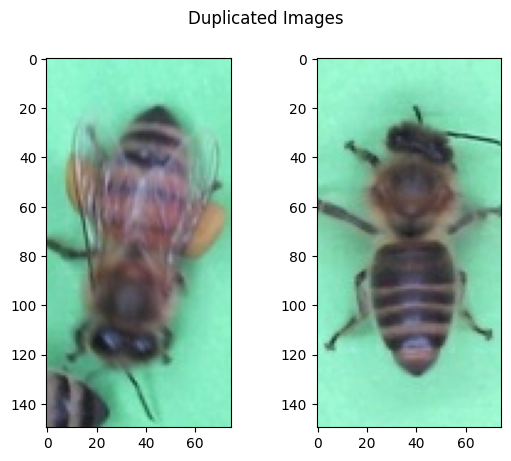

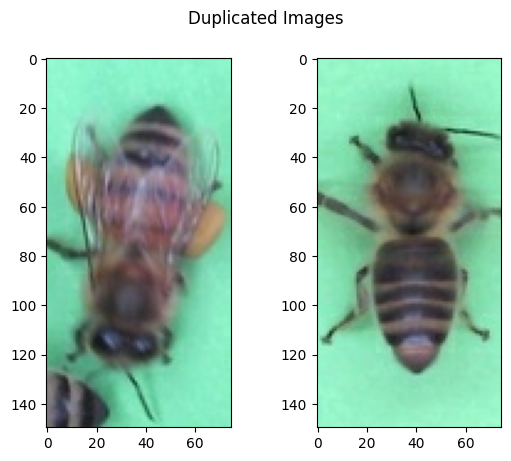

In [19]:
def plot_image(df,img_index,axe=None):
  """
get_image: Plots image
Arguments:
  df = DataFrame where images are stored
  img_index = position of image
  axe = pass axe to plot if subplots are needed
"""
  if axe is not None:
    #axe.imshow(tf.keras.utils.array_to_img(df.loc[img_index,'input']))
    axe.imshow(tf.keras.preprocessing.image.array_to_img(df.loc[img_index,'input']))
  else:
    #plt.imshow(tf.keras.utils.array_to_img(df.loc[img_index,'input']))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(df.loc[img_index,'input']))
    plt.show()

for i in range(0,len(dups)-1,2):
  #Set axis to plot images
  fig, (ax1, ax2) = plt.subplots(1,2)
  #Set title
  fig.suptitle("Duplicated Images")
  #Plot images
  plot_image(bee_df,dups[i],ax1)
  plot_image(bee_df,dups[i+1],ax2)

In [20]:
bee_df = bee_df.drop(dups)

In [21]:
"""
plot_class_counts: Plots a barplot with the respective number of instances existed on the dataset for a given target variable
Arguments:
  df = DataFrame to perform the counting (pd.DataFrame)
  target = target variable/class to count the number of examples (string)
  title = title of the plot (string)
  labels = labels to be plotted on the x axis (list of strings)
"""
def plot_class_counts(df,target,title,labels):
    fig,ax = plt.subplots(figsize=(6,6))
    #vals = df.value_counts(subset=[target])
    blist = plt.bar(labels,df.value_counts(subset=[target]),color=['#30A5BF','#F2BE22'])
    #blist[1].set_color('y')
    plt.title(title)
    total = len(df.values)
    for p in ax.patches:
      #Get percentages for classes
          percentage = '{:.1f}%'.format(100 * (p.get_height()/total))
          x = p.get_x() + p.get_width()/2 - 0.05
          y = p.get_y() + p.get_height() + 50
          ax.annotate(percentage, (x, y))
      #Get absolute values for classes
          x = p.get_x() + p.get_width()/2 - 0.05
          y = p.get_y() + p.get_height()/2
          ax.annotate(p.get_height(),(x,y))

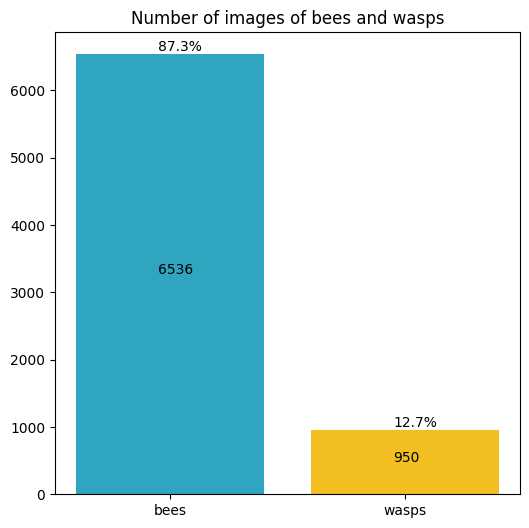

In [22]:
plot_class_counts(bee_df,'output/wasps_output','Number of images of bees and wasps',['bees','wasps'])

Primer ejercicio, separacion de avispas y abejas


In [25]:
bee_df_copy=bee_df

Normalizacion de las imagenes

In [26]:
bee_df_copy["input"]=bee_df_copy["input"]/255.0

En este apartado primero separare llas avispas de las abejas en un nuevo dataset para aplicarles Data augmentation y conseguir un numero equilibrado de la cantidad en ambas clases, aplicando rotacion, zoom, flip..., posteriormente mergeare el nuevo dataset generado con el antiguo para el modelo

In [27]:
# Selecciono un label específico para realizar el aumento de datos
target_label = 1.0

# Filtra el DataFrame para obtener solo las muestras con el label objetivo
df_target = bee_df[bee_df_copy["output/wasps_output"] == target_label]

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
df_target

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output,hash
13,"[[[0.5176470588235295, 0.8784313725490196, 0.7...",0,0,0,1,e026963b8f93c8cd
20,"[[[0.5098039215686274, 0.8666666666666667, 0.7...",0,0,0,1,eb60d81b98db1a8d
31,"[[[0.5019607843137255, 0.8352941176470589, 0.7...",0,0,0,1,e47a8355da83898f
38,"[[[0.48627450980392156, 0.8549019607843137, 0....",0,0,0,1,e231955e89ccd9d8
40,"[[[0.5254901960784314, 0.8901960784313725, 0.7...",0,0,0,1,e49a95e589665936
...,...,...,...,...,...,...
7369,"[[[0.49019607843137253, 0.8588235294117647, 0....",0,0,0,1,ab30c84fda8ada1e
7376,"[[[0.4980392156862745, 0.8705882352941177, 0.7...",0,0,0,1,be61859f8e8ac8e8
7397,"[[[0.5137254901960784, 0.8745098039215686, 0.7...",0,0,0,1,b8dad3a6ca248c73
7419,"[[[0.47058823529411764, 0.8509803921568627, 0....",0,0,0,1,e2da87e58c27cc32


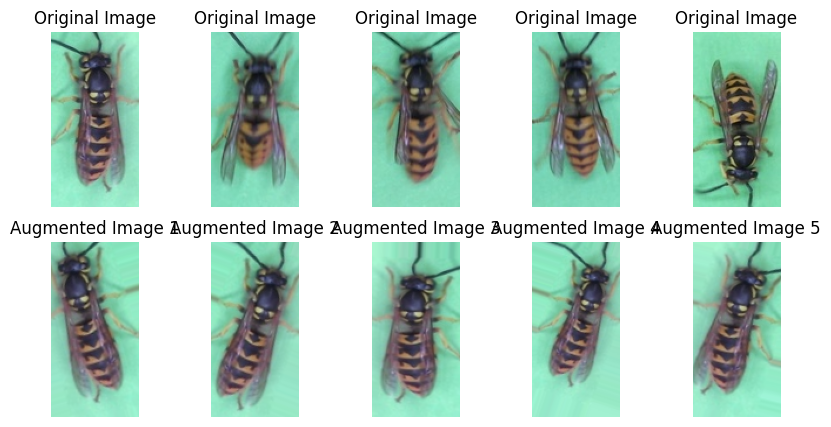

In [30]:
# Creo un generador de aumentos de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Aplico aumentos de datos a las imágenes asociadas con el label objetivo
augmented_images = []
for vector in df_target['input']:
    img_array = np.expand_dims(np.array(vector).reshape((150, 75, 3)), axis=0)
    for _ in range (6):
      augmented_image = datagen.flow(img_array).next()[0]
      augmented_images.append(augmented_image)

# Visualizo algunas imágenes originales y aumentadas
num_images_to_show = min(len(df_target), 5)
plt.figure(figsize=(10, 5))
for i in range(num_images_to_show):
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(df_target.iloc[i]['input'].reshape((150, 75,3)), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(augmented_images[i].reshape((150, 75,3)), cmap='gray')
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

plt.show()

In [31]:
augmented_df = pd.DataFrame({'input': augmented_images,"output/cooling_output":0.0,	"output/pollen_output":0.0,	"output/varroa_output":0.0, "output/wasps_output": 1.0})

In [32]:
augmented_df

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output
0,"[[[0.5507321, 0.8574891, 0.7222373], [0.542730...",0.0,0.0,0.0,1.0
1,"[[[0.56564206, 0.90880877, 0.7833186], [0.5616...",0.0,0.0,0.0,1.0
2,"[[[0.6642717, 0.97015405, 0.8172129], [0.66274...",0.0,0.0,0.0,1.0
3,"[[[0.5538627, 0.90888244, 0.77439195], [0.5548...",0.0,0.0,0.0,1.0
4,"[[[0.6494808, 0.95536315, 0.802422], [0.651425...",0.0,0.0,0.0,1.0
...,...,...,...,...,...
5695,"[[[0.5176471, 0.90588236, 0.73333335], [0.5176...",0.0,0.0,0.0,1.0
5696,"[[[0.5176471, 0.90588236, 0.73333335], [0.5176...",0.0,0.0,0.0,1.0
5697,"[[[0.4854387, 0.875376, 0.7092624], [0.4834717...",0.0,0.0,0.0,1.0
5698,"[[[0.5176471, 0.90588236, 0.73333335], [0.5176...",0.0,0.0,0.0,1.0


In [33]:
# Concatenar DataFrames
merged_df = pd.concat([bee_df_copy, augmented_df], ignore_index=True)

In [34]:
merged_df

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output,hash
0,"[[[0.34509803921568627, 0.3333333333333333, 0....",0.0,0.0,0.0,0.0,a60d87169ea3d9d8
1,"[[[0.5215686274509804, 0.8784313725490196, 0.7...",0.0,1.0,0.0,0.0,e738920fda8789d8
2,"[[[0.3568627450980392, 0.3686274509803922, 0.3...",0.0,1.0,0.0,0.0,a70fc8c307c9d333
3,"[[[0.592156862745098, 0.8901960784313725, 0.70...",0.0,1.0,0.0,0.0,b392c8678ecc8d53
4,"[[[0.5411764705882353, 0.8745098039215686, 0.7...",0.0,0.0,0.0,0.0,e57a84919ae5193e
...,...,...,...,...,...,...
13181,"[[[0.5176471, 0.90588236, 0.73333335], [0.5176...",0.0,0.0,0.0,1.0,NaN
13182,"[[[0.5176471, 0.90588236, 0.73333335], [0.5176...",0.0,0.0,0.0,1.0,NaN
13183,"[[[0.4854387, 0.875376, 0.7092624], [0.4834717...",0.0,0.0,0.0,1.0,NaN
13184,"[[[0.5176471, 0.90588236, 0.73333335], [0.5176...",0.0,0.0,0.0,1.0,NaN


In [35]:
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

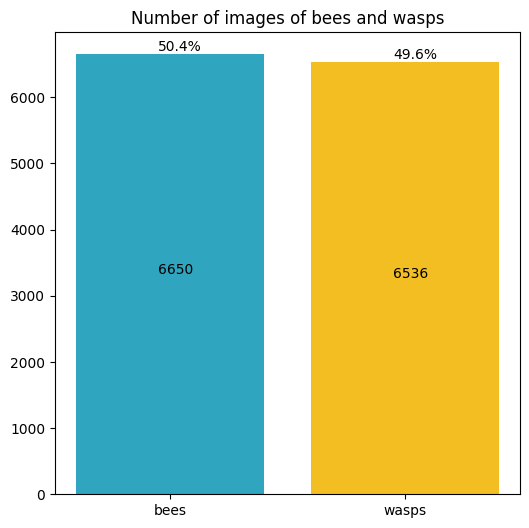

In [36]:
plot_class_counts(merged_df,'output/wasps_output','Number of images of bees and wasps',['bees','wasps'])

Separacion de imagenes y labels

In [37]:
X=[]
Y=[]

for i in range (len(merged_df)):
  image=merged_df["input"].loc[i]
  X.append(image)
  Y.append(merged_df["output/wasps_output"].loc[i])

In [38]:
X=np.array(X)
Y=np.array(Y)

Separacion en train y test

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [41]:
model = Sequential()

# Agregar capas convolucionales y de pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 75, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanar y agregar capas densa
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 73, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 7, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15232)             0

Entrenamiento del modelo

In [42]:
history = model.fit(X_train, y_train, epochs=20, batch_size = 80,
                    validation_data=(X_test, y_test))

Epoch 1/20
132/132 [==============================] - 26s 118ms/step - loss: 0.1362 - accuracy: 0.9389 - val_loss: 0.0286 - val_accuracy: 0.9928
Epoch 2/20
132/132 [==============================] - 12s 88ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.0217 - val_accuracy: 0.9913
Epoch 3/20
132/132 [==============================] - 12s 88ms/step - loss: 0.0135 - accuracy: 0.9957 - val_loss: 0.0102 - val_accuracy: 0.9962
Epoch 4/20
132/132 [==============================] - 12s 88ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0221 - val_accuracy: 0.9917
Epoch 5/20
132/132 [==============================] - 11s 85ms/step - loss: 0.0087 - accuracy: 0.9966 - val_loss: 0.0085 - val_accuracy: 0.9970
Epoch 6/20
132/132 [==============================] - 10s 79ms/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.0156 - val_accuracy: 0.9939
Epoch 7/20
132/132 [==============================] - 11s 82ms/step - loss: 0.0066 - accuracy: 0.9974 - val_loss: 0.0113 - val_accuracy

Graficas de visualizacion del entrenamiento

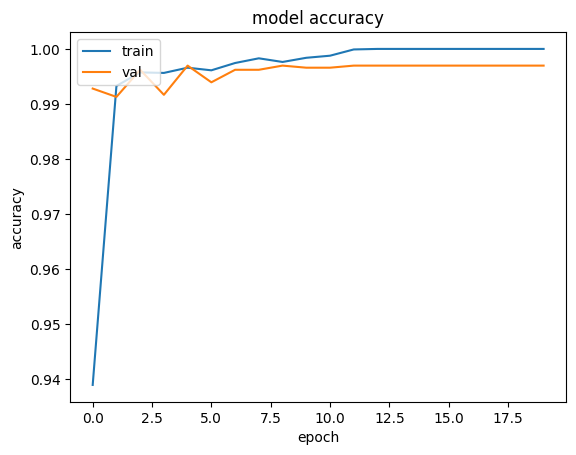

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

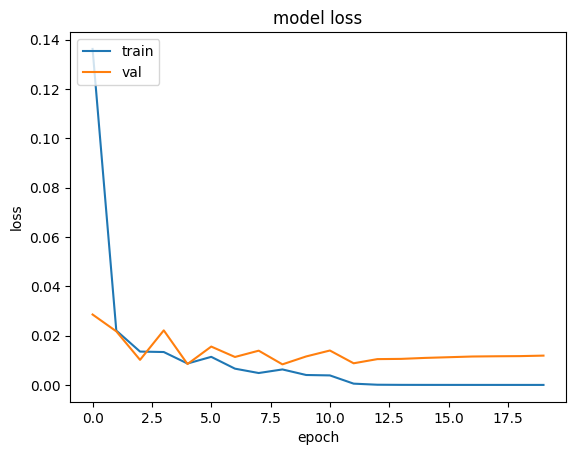

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
model.evaluate(X_test, y_test)

83/83 [==============================] - 2s 17ms/step - loss: 0.0119 - accuracy: 0.9970


[0.011884856037795544, 0.9969673752784729]

Vemos muy buen rendimiento con una precision muy buena, loss muy baja y sin overfit